### Anomaly Detection
- To indentify the data points that are different of the other data point
- There are 3 categories
    - Supervised Anomaly Dection: labels for both nomal and anomalous data
    - Semi-Supervised Anomaly Dectection: only label of nomal data 
    - Unsupervise Anomaly Dectection: no label is available
- Algorithms
    - Mahalanobis Distance: 
        - For one single dimension data, z-score can be used for outlier/anomaly detection. A data point is labeled as an anomaly if |z| > T (Threshold)
        - For multidimensional data, the z-score is not applicable. The Mahalanobis distance defined as https://en.wikipedia.org/wiki/Mahalanobis_distance
        
    - Density-based spatial clustering of application with noise (DBSCAN)
        - Find neighbors of all points of redius - Redius of defining neighborhood
        - Indentify a core point minimum number of datapoints required for formimng a local cluster
        - Find  the connected components of core point on the neighbors graph
        - Assign each non-core point to a nearby cluster if the cluster is an Redius of defining neighborhood, otherwise assign it to noise
    - Local Outlier Factor (LOF)
    - Isolation Forest
    - One-Class Support Vector Machine

In [107]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make dataset
from sklearn.datasets import make_blobs

# statistical modules for data generation and critical values
from scipy.stats import multivariate_normal, beta, uniform, t

from functools import partial

from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.covariance import EllipticEnvelope # use for Mohalanobis distance
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from typing import Any


In [108]:
class DBSCAND_outliner(DBSCAN):

    def __init__(self, eps = 0.5, *, min_samples = 5, metric = "euclidean", metric_params = None, algorithm = "auto", leaf_size = 30, p = None, n_jobs = None) -> None:
        super().__init__(eps, min_samples = min_samples, metric = metric, metric_params = metric_params, algorithm = algorithm, leaf_size = leaf_size, p = p, n_jobs = n_jobs)
        self._estimator_type = "outlier_detector"
        self._nbrs = NearestNeighbors(n_neighbors = 2)

    def fit_predict(self, X, y: Any = None) -> np.ndarray:
        labels = super().fit_predict(X, y, sample_weight = None)
        labels[labels > -1] = 1 # convert any non-negative cluster index to 1
        self._nbrs.fit(X = X[labels])
        return labels
    
    def fit(self, X, y = None, sample_weight = None):
        self._X = X # memorize the training samples
        super().fit(X = X)
        self._nbrs.fit(X = X[self.labels_ > -1])
        return self
    
    def decision_function(self, X):
        min_distance, _s = self._nbrs.kneighbors(X = X, n_neighbors = 1)
        scores = -min_distance[:, 0] + self.eps 
        return scores
    
    def predict(self, X):
        scores = self.decision_function(X)
        labels = np.zeros_like(scores, 'int')
        labels[scores >= 0] = 1
        labels[scores < 0] = -1
        return labels

In [109]:
# test 

eps = 1
min_points = 5

clf_dbscan = DBSCAN(eps = eps, min_samples = min_points)
clf_dbscan

DBSCAN(eps=1)

In [110]:
# create a dataset that have points from a single multivariate Gaussion population, then manuallu add a outlier into a dataset

np.random.seed(0) # random seed = 0
n = 1000 # 1000 samples
mu = np.array([0, 0]) # zero means
sigma = np.array([
    [2, 1],
    [1, 2]
])
normal = multivariate_normal.rvs(mean = mu, cov = sigma, size = n) # rvs: random variates of size (size, N), where N is the dimension of the random variable
normal

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-0.31140929, -0.17316878],
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187]])

In [111]:
len(normal)

1000

Text(0.5, 1.0, 'Unimodal Data with Single Anomaly')

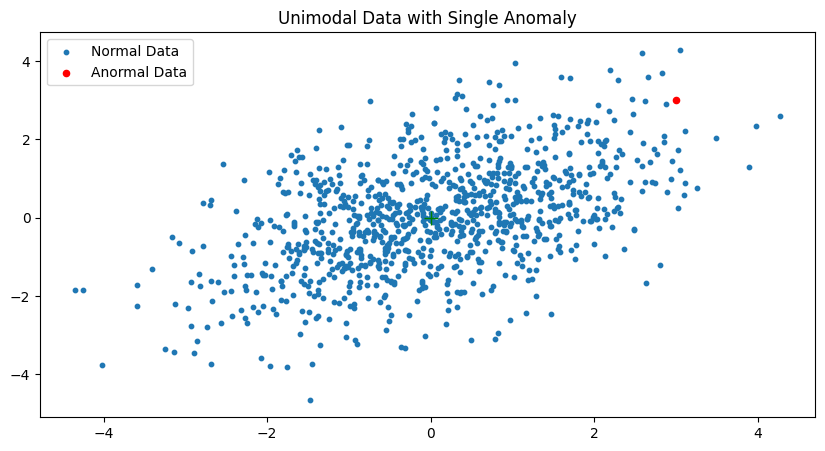

In [112]:
anomaly = np.array([3, 3])
anomaly = np.array([3, 3]).reshape(-1, 2) # anomaly data popint

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')
ax.plot([0], [0], marker = '+', color = 'green', markersize = 10) # mark the center
ax.scatter(anomaly[:, 0], anomaly[:, 1], s = 20, color = 'red', label = 'Anormal Data') # add anomaly data point

ax.legend()
ax.set_title('Unimodal Data with Single Anomaly')

In [113]:
# concate normal and anomaly together

dataset1 = np.concatenate((normal, anomaly)) # last item is the anomaly
dataset1

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187],
       [ 3.        ,  3.        ]])

In [114]:
# create labels: 0 for nomal, 1 for anomaly

label = np.concatenate([(np.zeros(n, )), np.ones(1, )])  # last item is the anomaly
label

array([0., 0., 0., ..., 0., 0., 1.])

In [115]:
len(label)

1001

In [116]:
# set params: elbow point (eps) must be larger enough to cover data points, min_points should be at least larger than the dimension of dataset +1

min_points = 3

nbrs = NearestNeighbors(n_neighbors = min_points)
nbrs.fit(X = dataset1) # train/fit
distances, index = nbrs.kneighbors(X = dataset1, n_neighbors = 2)

In [117]:
distances

array([[0.        , 0.08461608],
       [0.        , 0.10756274],
       [0.        , 0.32648974],
       ...,
       [0.        , 0.01308561],
       [0.        , 0.09669892],
       [0.        , 0.14916401]])

In [118]:
index

array([[   0,  724],
       [   1,  421],
       [   2,  512],
       ...,
       [ 998,  569],
       [ 999,  602],
       [1000,  278]])

In [119]:
distances2 = np.sort(distances, axis = 0)
distances2

array([[0.        , 0.00234166],
       [0.        , 0.00234166],
       [0.        , 0.00478677],
       ...,
       [0.        , 0.83848187],
       [0.        , 0.86345649],
       [0.        , 0.88363232]])

In [120]:
distances2 = distances2[: -1]
distances2

array([[0.        , 0.00234166],
       [0.        , 0.00234166],
       [0.        , 0.00478677],
       ...,
       [0.        , 0.61427748],
       [0.        , 0.83848187],
       [0.        , 0.86345649]])

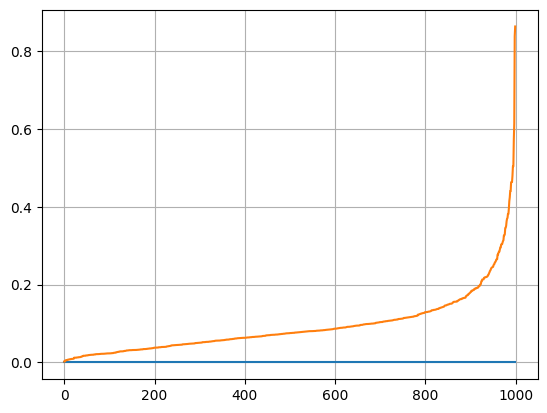

In [121]:
plt.plot(distances2)
plt.grid()

In [122]:
# refered to above graph, we can see the elbow point at maximum curvature is reounf 0.25

eps = 1
min_points = 3

In [123]:
clf_dbscan = DBSCAND_outliner(eps = eps, min_samples = min_points)
clf_dbscan

DBSCAND_outliner(eps=1, min_samples=3)

In [124]:
# fit/train model

clf_dbscan.fit(dataset1)

DBSCAND_outliner(eps=1, min_samples=3)

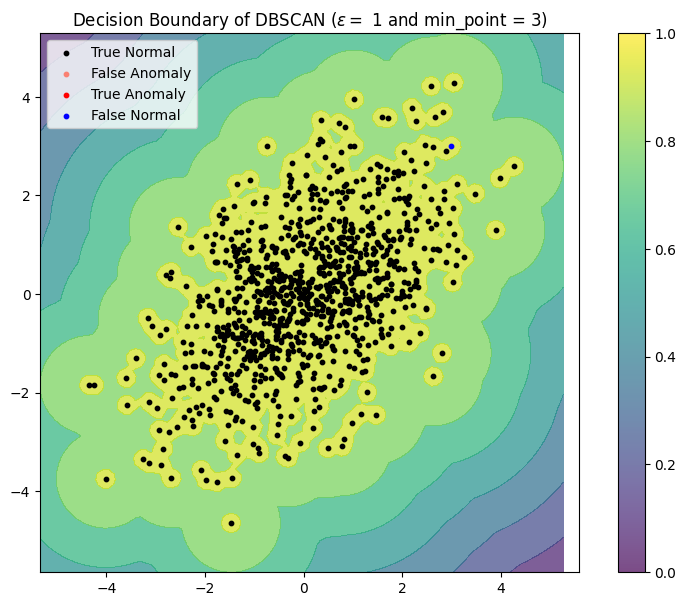

In [125]:
# Decision boundary and anomaly output

dataset = dataset1
normal_data = normal
anomaly_data = anomaly

# plot

fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_dbscan, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_dbscan.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_dbscan.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of DBSCAN ($\varepsilon=$ {} and min_point = {})".format(eps, min_points))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [126]:
# Performance evaluation

pred = clf_dbscan.predict(dataset1)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of DBSCAN Anomaly Detection Algorithm")
print(classification_report(label, pred, target_names = target_names))

Classification Report of DBSCAN Anomaly Detection Algorithm
              precision    recall  f1-score   support

       Nomal       1.00      1.00      1.00      1000
     Anomaly       0.00      0.00      0.00         1

    accuracy                           1.00      1001
   macro avg       0.50      0.50      0.50      1001
weighted avg       1.00      1.00      1.00      1001



/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi